In [7]:
import os
import scipy.io
import numpy as np
import gstools as gs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
%config InlineBackend.figure_format = 'svg'
config = {'font.family': 'Arial',
          'font.size': 12,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'mathtext.fontset': 'stix',
         }
plt.rcParams.update(config)

# 模型结构绘制

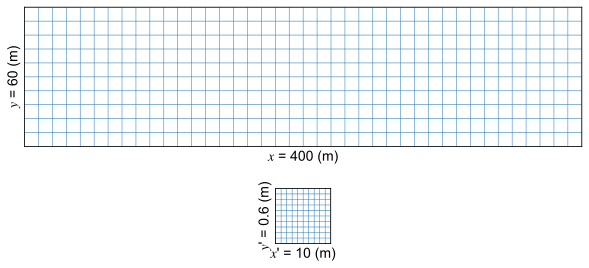

In [4]:
cols1, rows1 = 40, 10
cols2, rows2 = 10, 10

# 创建 Figure，并用 GridSpec 分配高度比例
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(2, 1,
                      height_ratios=[4, 1],  # 子图1：子图2 = 32:1
                      hspace=0.01)            # 控制子图间距

# --- 大子图 ---
ax1 = fig.add_subplot(gs[0])
for x in range(cols1 + 1):
    ax1.axvline(x, linewidth=0.5)
for y in range(rows1 + 1):
    ax1.axhline(y, linewidth=0.5)
ax1.set_xlim(0, cols1)
ax1.set_ylim(0, rows1)
ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel(r'$x$ = 400 (m)')
ax1.set_ylabel(r'$y$ = 60 (m)')

# --- 小子图 ---
ax2 = fig.add_subplot(gs[1])
for x in range(cols2 + 1):
    ax2.axvline(x, linewidth=0.5)
for y in range(rows2 + 1):
    ax2.axhline(y, linewidth=0.5)
ax2.set_xlim(0, cols2)
ax2.set_ylim(0, rows2)
ax2.set_aspect('equal')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel(r"$x$' = 10 (m)")
ax2.set_ylabel(r"$y$' = 0.6 (m)")

plt.show()

## 场景 一 结构变化

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import gstools as gs

def K_generator(
    var=2.5,
    scale=15,
    scale_ratio=0.3,
    seed=181,
    transform_flag=None,
):
    model = gs.Matern(dim=2, var=var, len_scale=[scale * scale_ratio, scale], nu=1)
    srf = gs.SRF(model, seed=seed)
    field = srf.structured([np.arange(100), np.arange(400)])

    if transform_flag == "con":
        field = srf.transform("zinnharvey", conn="high")
    elif transform_flag == "dcon":
        field = srf.transform("zinnharvey", conn="low")
    elif transform_flag is not None:
        field = srf.transform(transform_flag)

    return np.exp(field)


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import seaborn as sns

def plot_k(field_scaled, vmin=None, vmax=None):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2.2), 
                             gridspec_kw={'width_ratios': [3, 1]})
    # 自动取 min/max
    if vmin is None:
        vmin = field_scaled.min()
    if vmax is None:
        vmax = field_scaled.max()

    # 对数归一化
    norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    im = axes[0].imshow(field_scaled, cmap="jet", norm=norm, aspect='auto')

    # 打印范围
    print("Min:", vmin)
    print("Max:", vmax)

    # 创建 colorbar，并指定 LogLocator
    cbar = plt.colorbar(
        im, ax=axes[0],
        fraction=0.046, pad=0.04,
        ticks=ticker.LogLocator(base=10.0, subs=(1.0,))  # 仅在 10^n 处添加刻度
    )
    # 只显示 10^n 形式的标签
    cbar.ax.yaxis.set_major_formatter(
        ticker.LogFormatterMathtext(base=10, labelOnlyBase=True)
    )

    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # 右侧 KDE
    sns.kdeplot(np.log(field_scaled).flatten(), ax=axes[1],
                fill=True, color='red', alpha=0.2)
    axes[1].set_ylabel("")
    plt.show()



def safe_save(arr, fname):
    """确保目录存在，将输入转换为纯 ndarray 再保存，避免文件 seek 错误"""
    out_dir = os.path.dirname(fname)
    os.makedirs(out_dir, exist_ok=True)
    # 转换为纯 ndarray，去除可能的 mask
    arr_np = np.array(arr)
    # 保存时直接传入文件名，由 numpy 内部处理打开并支持 seek
    np.save(fname, arr_np)

Min: 0.0065029982395064965
Max: 109.23644768288503


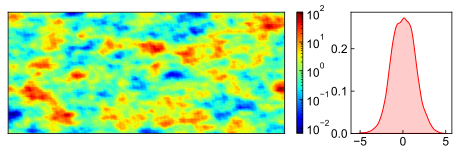

Min: 0.009011799604211992
Max: 1390.9832503198309


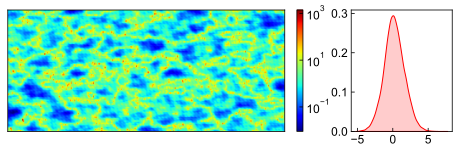

Min: 0.0007189159177654142
Max: 110.96562772352524


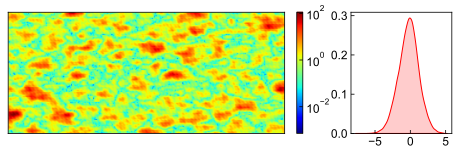

Min: 0.12999554319275808
Max: 7.684480908796402


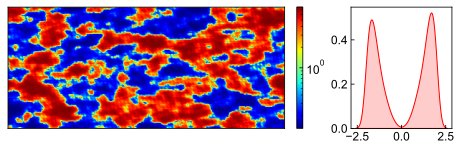

In [10]:
out_dir = "./input_data/mycase/init_hk/00_structures"
os.makedirs(out_dir, exist_ok=True)

# 0. 均质场
field_scaled = np.ones((100, 400))
# safe_save(field_scaled, os.path.join(out_dir, "base.npy"))
# plot_k(field_scaled)

# 1. 原始随机场
field_scaled = K_generator(seed=3, var=2.5, scale=15)
# safe_save(field_scaled, os.path.join(out_dir, "gaussian.npy"))
plot_k(field_scaled)

# 2. 高连通性变换
field_scaled = K_generator(seed=3, var=2.5, scale=15, transform_flag="con")
# safe_save(field_scaled, os.path.join(out_dir, "acon.npy"))
plot_k(field_scaled)

# 3. 低连通性变换
field_scaled = K_generator(seed=3, var=2.5, scale=15, transform_flag="dcon")
# safe_save(field_scaled, os.path.join(out_dir, "dcon.npy"))
plot_k(field_scaled)

# 4. normal_to_uquad 变换
field_scaled = K_generator(seed=3, var=2.5, scale=15, transform_flag="normal_to_uquad")
# safe_save(field_scaled, os.path.join(out_dir, "uquad.npy"))
plot_k(field_scaled)

# 场景二 参数变化

Min: 0.0001
Max: 300.0


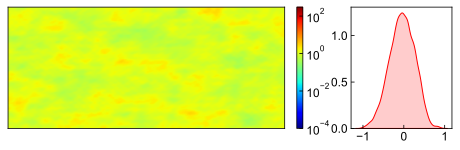

Min: 0.0001
Max: 300.0


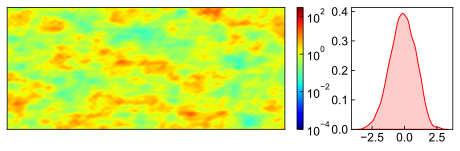

Min: 0.0001
Max: 300.0


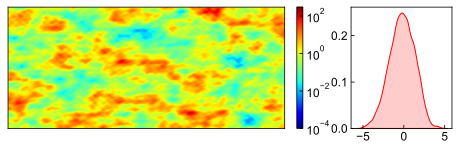

Min: 0.0001
Max: 300.0


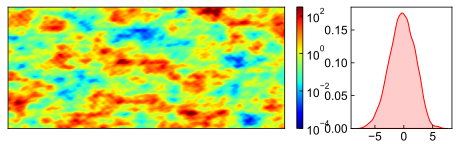

In [14]:
# 1) 要测试的方差列表
var_list = [0.1, 1.0, 2.5, 5.0]

# 2) 每个方差下要生成的样本数
num_samples = 1

# 3) 用一个固定的基准随机数生成器来产生种子，保证可重复
base_rng = np.random.RandomState(42)

def plot_k(field_scaled, vmin=None, vmax=None):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2.2), 
                             gridspec_kw={'width_ratios': [3, 1]})
    # 自动取 min/max
    if vmin is None:
        vmin = field_scaled.min()
    if vmax is None:
        vmax = field_scaled.max()

    # 对数归一化
    norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    im = axes[0].imshow(field_scaled, cmap="jet", norm=norm, aspect='auto')

    # 打印范围
    print("Min:", vmin)
    print("Max:", vmax)

    # 创建 colorbar，并指定 LogLocator
    cbar = plt.colorbar(
        im, ax=axes[0],
        fraction=0.046, pad=0.04,
        ticks=ticker.LogLocator(base=10.0, subs=(1.0,))  # 仅在 10^n 处添加刻度
    )
    # 只显示 10^n 形式的标签
    cbar.ax.yaxis.set_major_formatter(
        ticker.LogFormatterMathtext(base=10, labelOnlyBase=True)
    )

    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # 右侧 KDE
    sns.kdeplot(np.log(field_scaled).flatten(), ax=axes[1],
                fill=True, color='red', alpha=0.2)
    axes[1].set_ylabel("")
    plt.show()

for var in var_list:
    out_dir = f"./input_data/mycase/init_hk/var_{var}"
    os.makedirs(out_dir, exist_ok=True)
    
    # 4) 直接随机抽取 num_samples 个种子
    seeds = base_rng.randint(low=0, high=100000, size=num_samples)

    for seed in seeds:
        field_scaled = K_generator(seed=181, var=var)
        # safe_save(field_scaled, os.path.join(out_dir, f"var_{var}_seed_{seed}.npy"))
        plot_k(field_scaled, vmin=0.0001, vmax=300.0)

Min: 0.002615901774175768
Max: 926.0475277497113


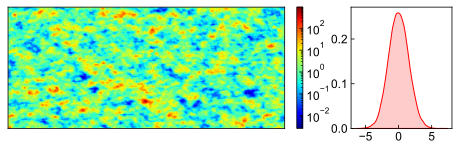

Min: 0.010853273668886668
Max: 155.28778139189413


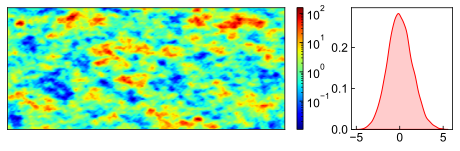

Min: 0.012065994862118675
Max: 157.50885652127124


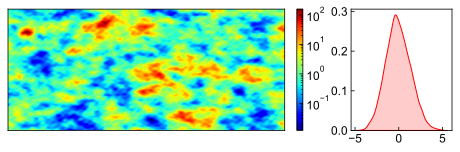

Min: 0.018368973581236726
Max: 157.50885652127124


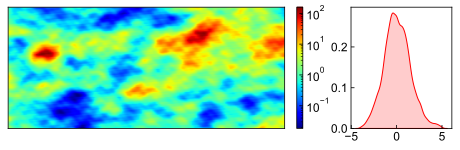

In [15]:
# 相关长度测试列表
scale_list = [5, 10, 15, 30]

num_samples = 1

base_rng = np.random.RandomState(43)

for scale in scale_list:
    out_dir = f"./input_data/mycase/init_hk/scale_{scale}"
    os.makedirs(out_dir, exist_ok=True)
    seeds = base_rng.randint(0, 100000, size=num_samples)

    for seed in seeds:
        field_scaled = K_generator(scale=scale, seed=1969)
        # safe_save(field_scaled, os.path.join(out_dir, f"scale_{scale}_seed_{seed}.npy"))
        plot_k(field_scaled)

Min: 0.003870190655899911
Max: 338.47643756455847


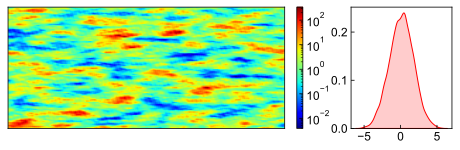

Min: 0.004643282443367614
Max: 369.86550502971227


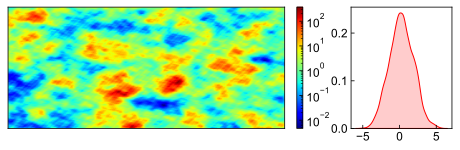

Min: 0.006091255997495974
Max: 134.17833261096953


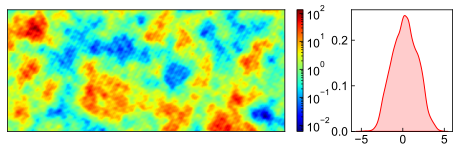

Min: 0.023927470269821047
Max: 139.53406706505345


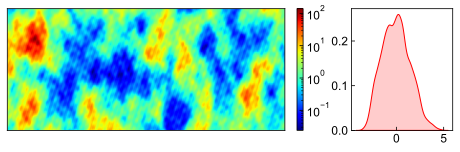

In [16]:
# 各向异性测试列表（纵横尺度比）
scale_ratio_list = [0.1, 0.3, 0.6, 1.0]

num_samples = 1

base_rng = np.random.RandomState(44)

for scale_ratio in scale_ratio_list:
    out_dir = f"./input_data/mycase/init_hk/sr_{scale_ratio}"
    os.makedirs(out_dir, exist_ok=True)
    seeds = base_rng.randint(0, 100000, size=num_samples)

    for seed in seeds:
        field_scaled = K_generator(
            scale_ratio=scale_ratio,
            seed=76
        )
        # safe_save(field_scaled, os.path.join(out_dir, f"sr_{scale_ratio}_seed_{seed}.npy"))
        plot_k(field_scaled)


ValueError: 'bottom' is not a valid value for position; supported values are 'left', 'right'

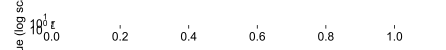

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colorbar as mcolorbar

# 参数设置：调整下面两个变量来控制 colorbar 的总长度和厚度
fig_width  = 6   # 整体 figure 的宽度（英寸）
fig_height = 0.5   # 整体 figure 的高度（英寸）

# 在 figure 中添加一个单独的坐标轴用于放 colorbar：
# [left, bottom, width, height]（都取 0-1 之间的相对值）
left, bottom = 0.1, 0.4
bar_width  = 0.8  # colorbar 在 figure 中的宽度（相对）
bar_height = 0.2  # colorbar 的高度（相对）
fig = plt.figure(figsize=(fig_width, fig_height))
cax = fig.add_axes([left, bottom, bar_width, bar_height])

# 创建对数归一化器
norm = mcolors.LogNorm(vmin=1e-3, vmax=1e2)

# 绘制 colorbar
cb = mcolorbar.ColorbarBase(
    cax,
    norm=norm,
    orientation='horizontal',            # 水平放置
    ticks=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2],  # 指定刻度
    ticklocation='bottom',               # 刻度位置
    label='Value (log scale)',            # 如果需要标签
    cmap="jet"
)

# 美化刻度标签为科学计数法
cax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"$10^{{{int(np.log10(x))}}}$"))

plt.show()


# MIX

Min: , 0.3
Max: , 1.0


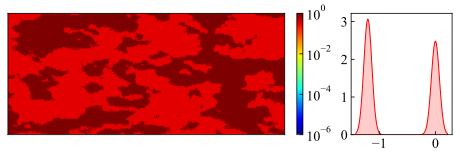

In [7]:
out_dir = "./input_data/mycase/init_hk/mix"
os.makedirs(out_dir, exist_ok=True)

field_scaled = K_generator(seed=986, var=2.5, scale=15, transform_flag="binary")

field_scaled = np.interp(field_scaled, (field_scaled.min(), field_scaled.max()), (1.0, 0.3))
safe_save(field_scaled, os.path.join(out_dir, "minerials_negative.npy"))
plot_k(field_scaled, vmin=1e-6, vmax=1.0)


In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(8, 2.2), gridspec_kw={'width_ratios': [3, 1]})
im = axes[0].imshow(field_scaled, aspect='auto')
plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)
axes[0].set_xticks([])
axes[0].set_yticks([])

sns.kdeplot(np.log(field_scaled).flatten(), ax=axes[1], fill=True, color='red', alpha=0.2)
axes[1].set_ylabel("")
plt.show()

Min: , 0.008617732634522297
Max: , 190.9472235153893


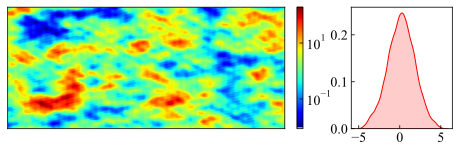

In [3]:
# 1. 原始随机场
field_scaled = K_generator(seed=986, var=2.5, scale=15)
# safe_save(field_scaled, os.path.join(out_dir, "K.npy"))
plot_k(field_scaled)

In [ ]:
plt.imshow(np.load("./input_data/mycase/init_hk/mix/minerials_negative.npy"))
plt.colorbar()


# 剖面边界

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.interpolate import interp1d

# # 1. 定义网格尺寸
# rows = 100
# cols = 400

# # 2. 初始化网格
# profile = np.ones((rows, cols))

# # 3. 定义曲线边界的关键点 (x, y) - 调整以匹配橙色线
# #    x 是列索引 (0 到 cols-1)
# #    y 是行索引 (0 到 rows-1, 0是顶部, 99是底部)
# #    !!! 使用新的 Y 值来模拟橙色线的位置 !!!
# key_points_x = np.array([0,   50,  200, 350, cols - 1]) # 调整x坐标以更好地定义最低点
# key_points_y = np.array([5,   70,  98,  70,  5])      # !!! 这些是新的Y值，两端靠近顶部(小索引), 中间靠近底部(大索引)!!!

# # 检查y坐标
# if np.any(key_points_y < 0) or np.any(key_points_y >= rows):
#     print("警告：关键点的 Y 坐标超出了行范围 [0, {}]，请调整。".format(rows - 1))
#     key_points_y = np.clip(key_points_y, 0, rows - 1)

# # 4. 使用三次样条插值
# x_coords = np.arange(cols)
# interpolation_func = interp1d(key_points_x, key_points_y, kind='cubic', bounds_error=False, fill_value="extrapolate")
# boundary_y_coords = interpolation_func(x_coords).astype(int)
# boundary_y_coords = np.clip(boundary_y_coords, 0, rows - 1)

# # 5. 根据边界填充值 (上 -1, 下 1)
# yy, xx = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')
# boundary_grid = boundary_y_coords[xx]
# profile.fill(-1) # 默认上方
# mask_below_boundary = yy > boundary_grid
# profile[mask_below_boundary] = 1 # 下方区域

# # --- (可选) 可视化结果 ---
# plt.figure(figsize=(12, 4))
# plt.imshow(profile, aspect='auto', cmap='coolwarm', extent=[0, cols, rows, 0], vmin=-1, vmax=1)
# plt.plot(x_coords + 0.5, boundary_y_coords + 0.5, color='black', linewidth=2, linestyle='--', label='Boundary Curve (New)')
# plt.colorbar(label="Profile Value", ticks=[-1, 1])
# plt.title("Generated 2D Profile (100x400) - Adjusted Boundary")
# plt.xlabel("Column Index")
# plt.ylabel("Row Index")
# plt.legend()
# # plt.gca().invert_yaxis()
# plt.grid(False)
# plt.show()

# # 保存数据
# # np.savetxt("profile_data_adjusted.txt", profile, fmt='%d')